# Alignement of hierarchies of segmentations

This notebook contains a demonstration on how to use the hierarchy alignement function in order to combine two hierarchies whose contour positions do not match perfectly.

We will start by building two mean contour hierarchies on a multiscale gradient with a fine and a coarse resolution.
We will then align the boundaries of the hierarchy constructed on the coarse gradient with the boundaries of the hierarchy constructed on the fine gradient.
This will allow us to easily merge the two hierarchies.

The overall process described in this notebook exposes the basics of the inner functionning of the function
`op = hg.multiscale_mean_pb_hierarchy` which is an efficient implementation of the method described in:

    J. Pont-Tuset, P. Arbeláez, J. Barron, F. Marques, and J. Malik
    Multiscale Combinatorial Grouping for Image Segmentation and Object Proposal Generation
    IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI), vol. 39, no. 1, pp. 128 - 140, 2017.
    
and in:

    K.K. Maninis, J. Pont-Tuset, P. Arbeláez and L. Van Gool
    Convolutional Oriented Boundaries: From Image Segmentation to High-Level Tasks
    IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI), vol. 40, no. 4, pp. 819 - 833, 2018.


## Fine and coarse hierachies

In [1]:
%%capture
!pip install higra

In [2]:
#usual import, setup, and magic
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
import higra as hg

try:
    from utils import * # imshow, locate_resource, get_sed_model_file
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())

We will demonstrate the process on a classical bsds image.

Image size: (481, 321)


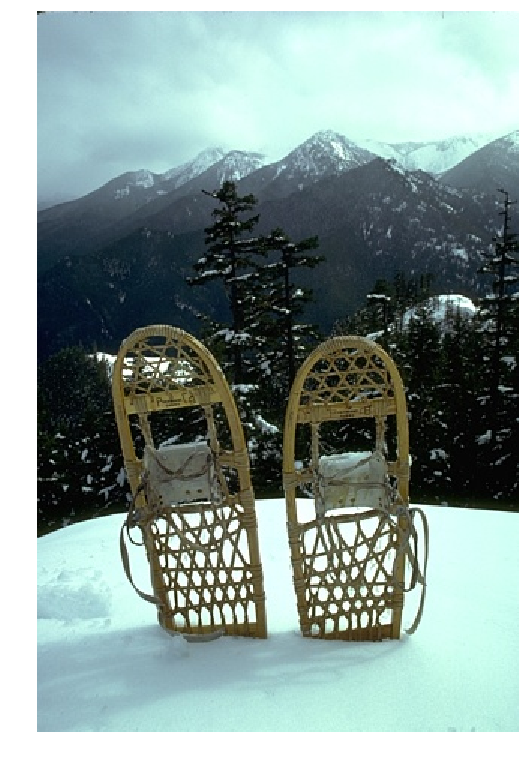

(<Figure size 481.5x721.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f6309e1e7b8>)

In [3]:
image = imageio.imread(locate_resource("2018.ppm"))
# switch to float to avoir numerical issue with uint8
image = image.astype(np.float64)/255 
# discard the color channel
size = image.shape[:2]
print("Image size:", size)
imshow(image)

We will load the pre-computed gradients (and edge orientation) from the Convolutional Oriented Boundary (COB) method

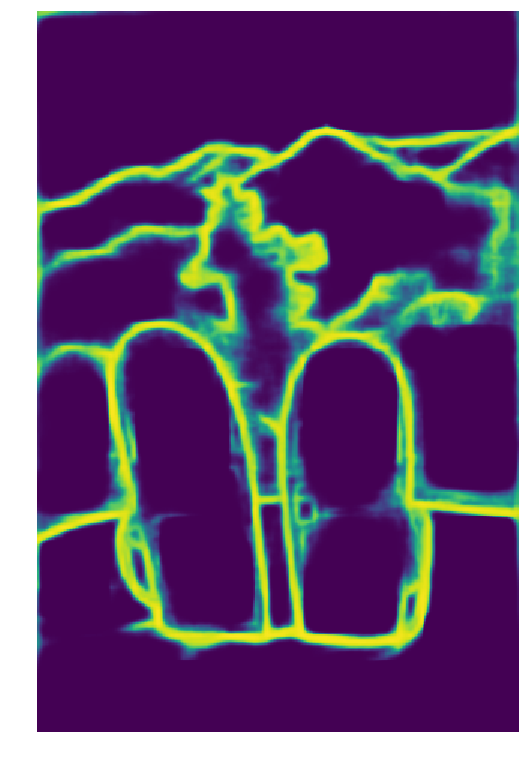

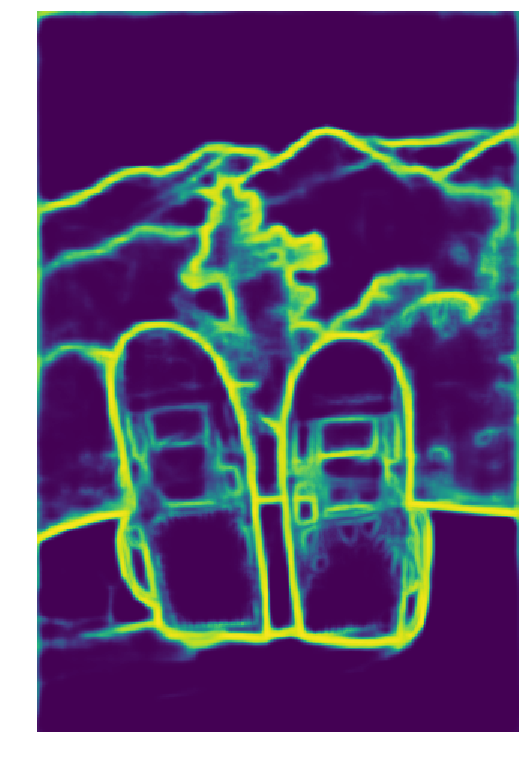

(<Figure size 481.5x721.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f630417dc50>)

In [4]:
import scipy.io as sio
cob_results = sio.loadmat(locate_resource("2018_cob.mat"))

# the internal organisation of mat files is a bit weired...
gradient_coarse = cob_results["E"][0][1]
gradient_fine = cob_results["E"][0][0] 
gradient_orientation = cob_results["O"]["angle"][0][0]
imshow(gradient_coarse)
imshow(gradient_fine)



Now let's construct the edge weighted graphs associated to those two gradients.

In [5]:
graph = hg.get_4_adjacency_graph(size)
edge_weights_fine = hg.weight_graph(graph, gradient_fine, hg.WeightFunction.mean)
edge_weights_coarse = hg.weight_graph(graph, gradient_coarse, hg.WeightFunction.mean)

# special handling for angles to wrap around the trigonometric cycle...
edge_orientations_source = hg.weight_graph(graph, gradient_orientation, hg.WeightFunction.source) 
edge_orientations_target = hg.weight_graph(graph, gradient_orientation, hg.WeightFunction.target) 
edge_orientations = hg.mean_angle_mod_pi(edge_orientations_source, edge_orientations_target)

We can now compute the fine hierarchy

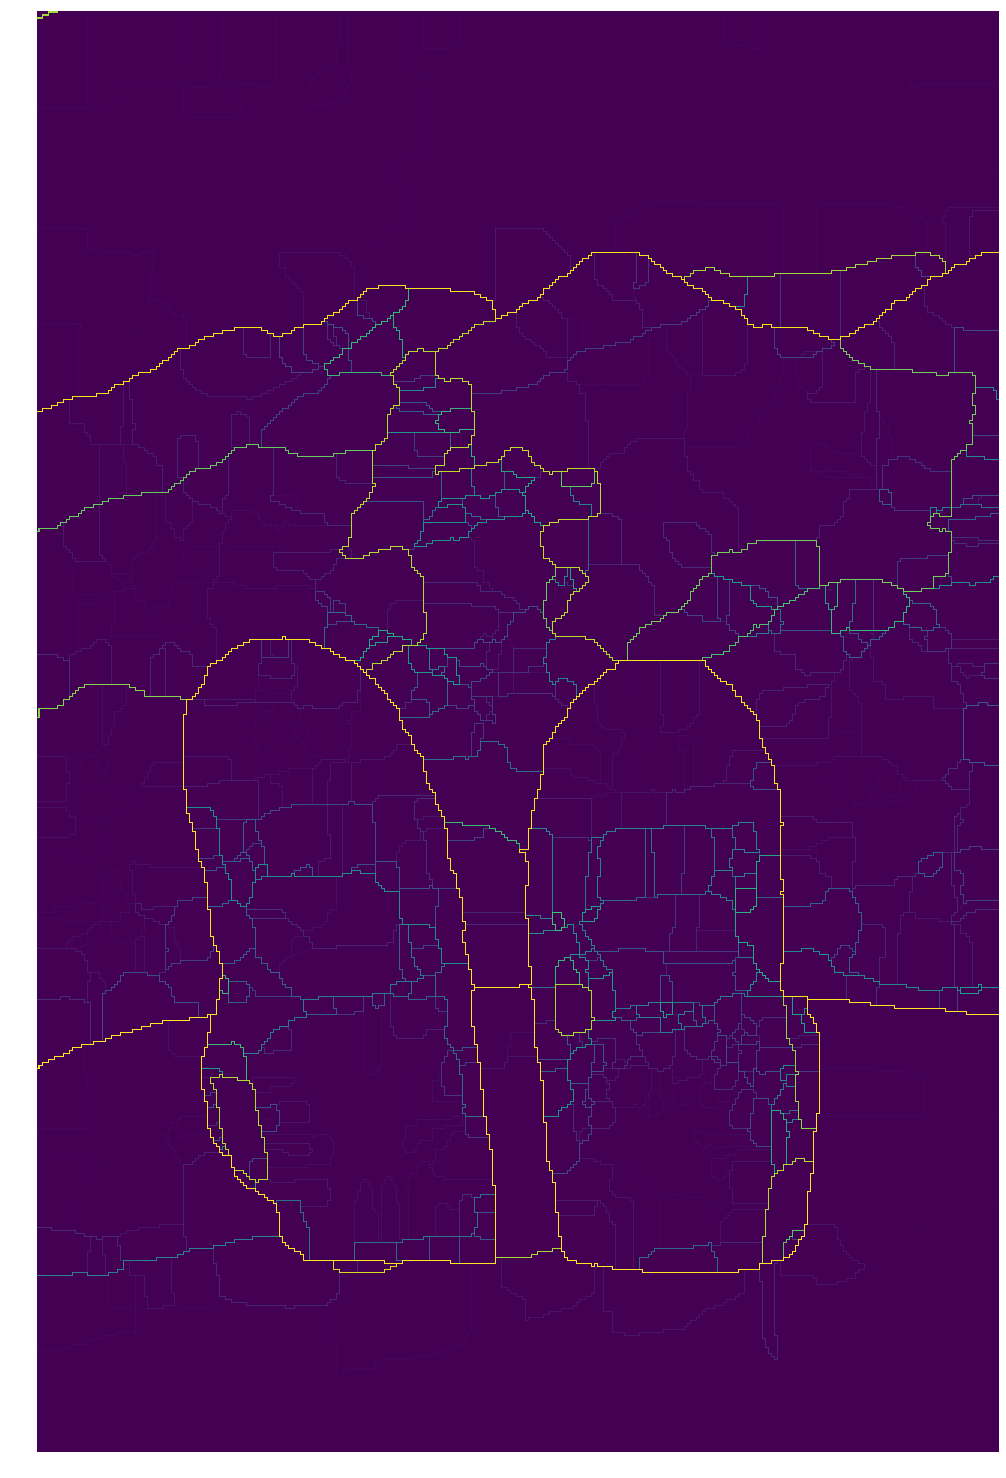

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f6304146048>)

In [6]:
hierarchy_fine, altitudes_fine = hg.mean_pb_hierarchy(graph, edge_weights_fine, edge_orientations=edge_orientations)
saliency_fine = hg.saliency(hierarchy_fine, altitudes_fine)
saliency_fine_khalimsky = hg.graph_4_adjacency_2_khalimsky(graph, saliency_fine)
imshow(saliency_fine_khalimsky)

And the coarse one:

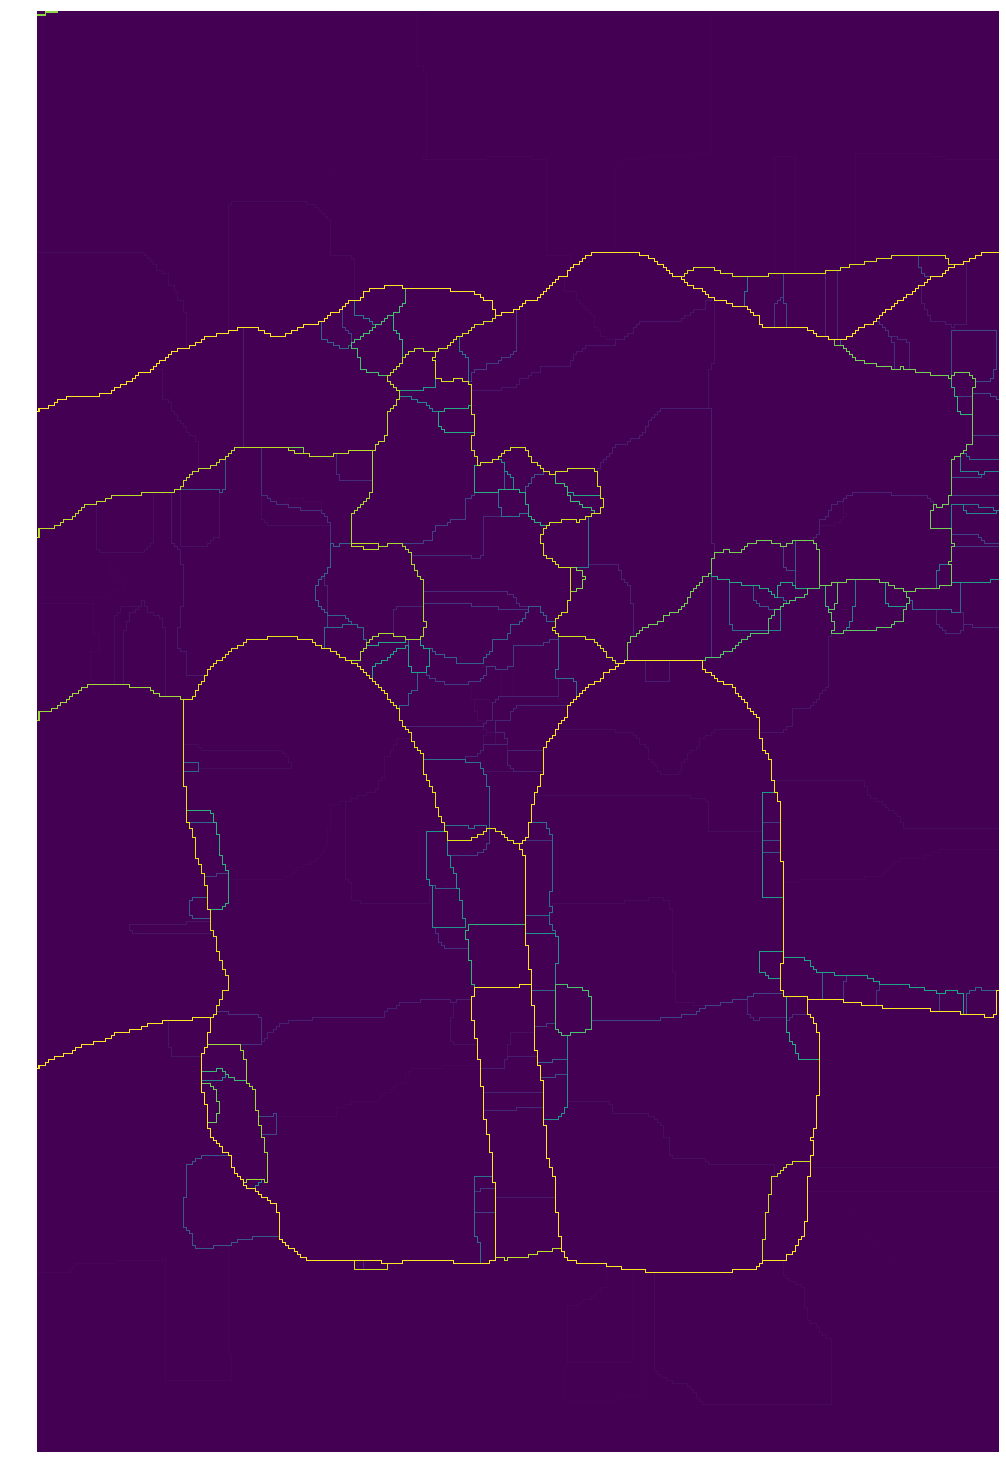

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f6304125240>)

In [7]:
hierarchy_coarse, altitudes_coarse = hg.mean_pb_hierarchy(graph, edge_weights_coarse, edge_orientations=edge_orientations)
saliency_coarse_khalimsky = hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(hierarchy_coarse,altitudes_coarse))
imshow(saliency_coarse_khalimsky)

Intuitively we would like to combine the coarse and fine saliency maps. However, we can see that the positions of theirs contours slightly differ which prevents us from doing so. 

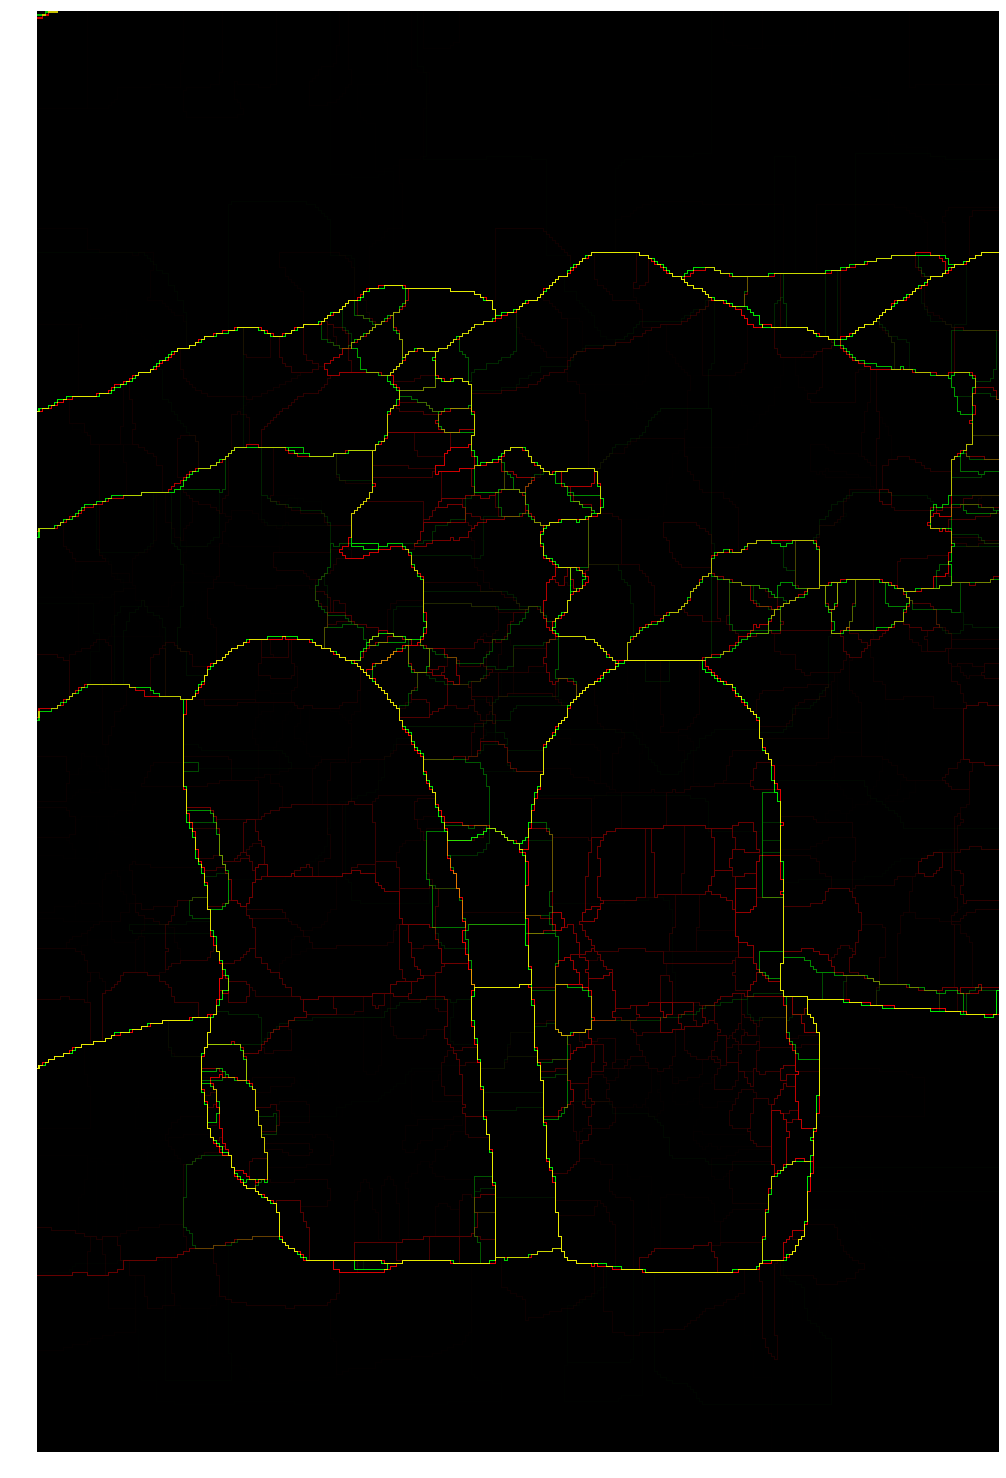

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f630407ef28>)

In [8]:
superimposed_saliency_maps = np.dstack((saliency_fine_khalimsky,saliency_coarse_khalimsky, np.zeros(saliency_fine_khalimsky.shape)))
imshow(superimposed_saliency_maps)                        

## Hierarchy alignement

The `align_hierarchies` function offers a solution to this problem by providing a way to align the contours of a hierarchy on a set of pre-defined contours.
In our case, we will align the contours of the coarse hiearchy on the contours of the supervertices of the fine hierarchy.

In [9]:
help(hg.align_hierarchies)

Help on function align_hierarchies in module higra.algo.alignment:

align_hierarchies(graph, vertex_labels, other_hierarchies)
    Align hierarchies boundaries on the boundaries of the provided super-vertex decomposition of a graph
    
    Given:
    
        - a graph :math:`G=(V,E)`
        - a fine labelisation :math:`l_1` of the vertices of :math:`G`;
        - a tree :math:`T` on :math:`G` whose supervertices corresponds to the coarse labelisation :math:`l_2`
          of the vertices of :math:`G`; and
        - the altitudes :math:`a` of the nodes of :math:`T`.
    
    Let us denote:
    
        - given a vertex :math:`x` of :math:`G` and a labelisation :math:`l`, :math:`l(x)` is the region of :math:`l`
          that contains :math:`x`
        - given a region :math:`r` of :math:`l_1`, :math:`s(r, l_2)` is the region :math:`R` of :math:`l_2` that has
          the largest intersection with :math:`r`, ie, :math:`s(r, l_2) = \arg \max_{R \in l_2} | R \cap r |`
    
    The proj

Thus, first things we need are the supervertices of the fine hierarchy:

In [10]:
super_vertex_fine = hg.labelisation_hierarchy_supervertices(hierarchy_fine, altitudes_fine)

We can now simply align our coarse hierarchy on the fine super-vertices

In [11]:
saliency_coarse_aligned = hg.align_hierarchies(graph, super_vertex_fine, (hierarchy_coarse, altitudes_coarse))

We can visualize the result: much nicer !

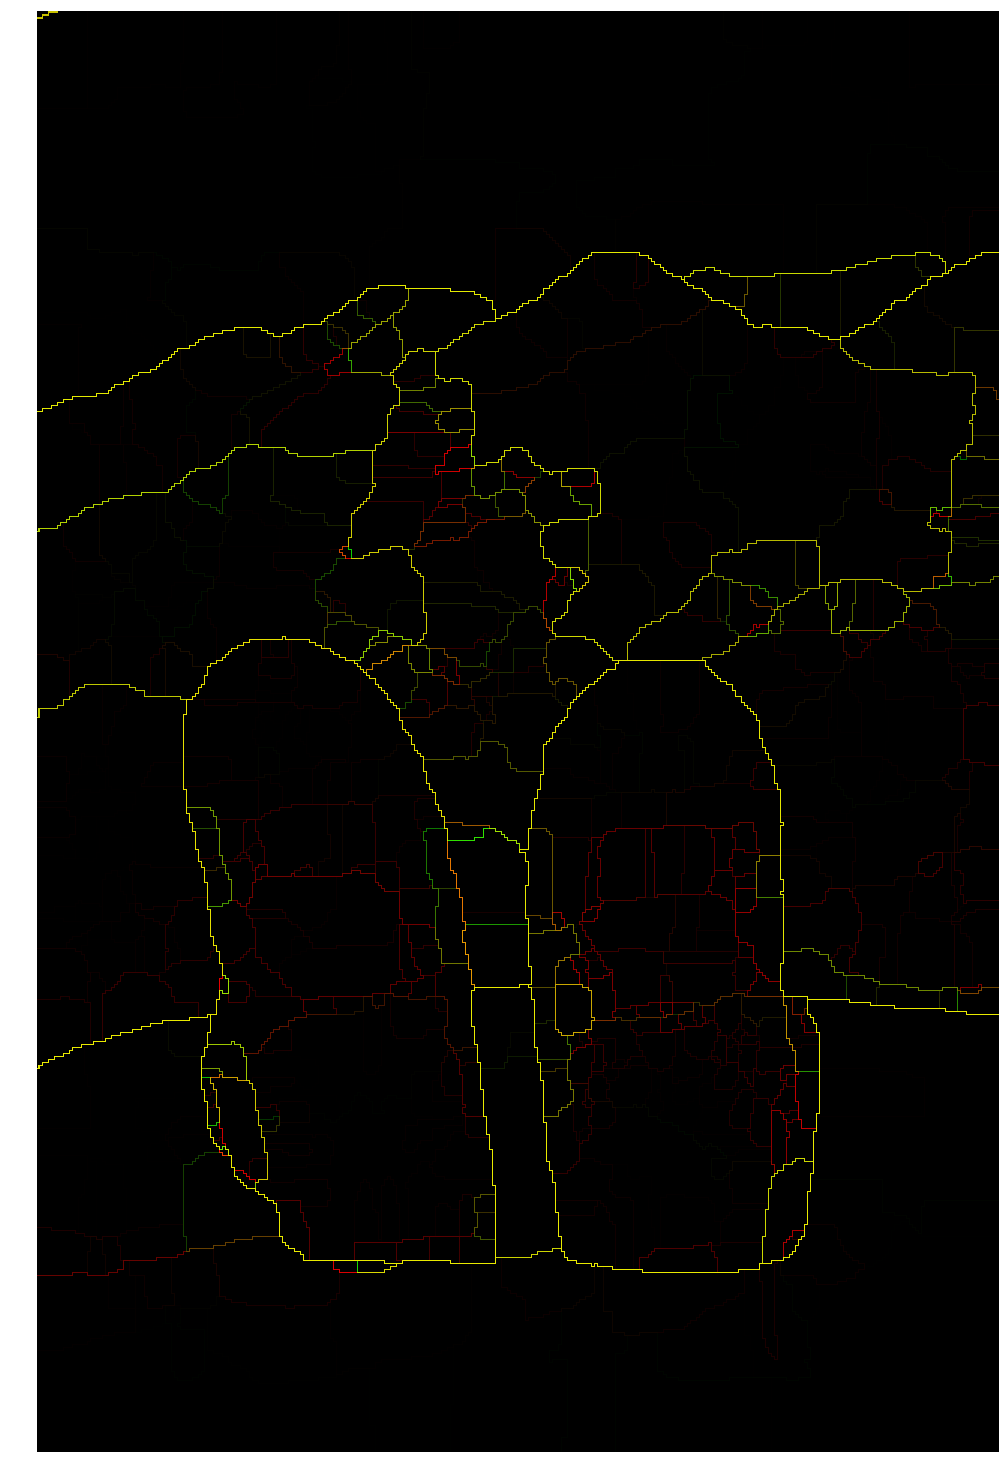

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f63041865f8>)

In [12]:
saliency_coarse_aligned_khalimsky = hg.graph_4_adjacency_2_khalimsky(graph, saliency_coarse_aligned)
superimposed_saliency_maps_aligned = np.dstack((saliency_fine_khalimsky, saliency_coarse_aligned_khalimsky, np.zeros(saliency_fine_khalimsky.shape)))
imshow(superimposed_saliency_maps_aligned) 

## Combination of aligned saliency maps

Several works have shown that a simple average combination of saliency maps is an efficient strategy.
However, the average of two saliency maps is generally not a saliency map, we will thus use those new edge weights to compute a new hierarchy.

In [13]:
saliency_combined = (saliency_coarse_aligned + saliency_fine) * 0.5
combined_hierarchy, altitudes_combined = hg.mean_pb_hierarchy(graph, saliency_combined, edge_orientations=edge_orientations)

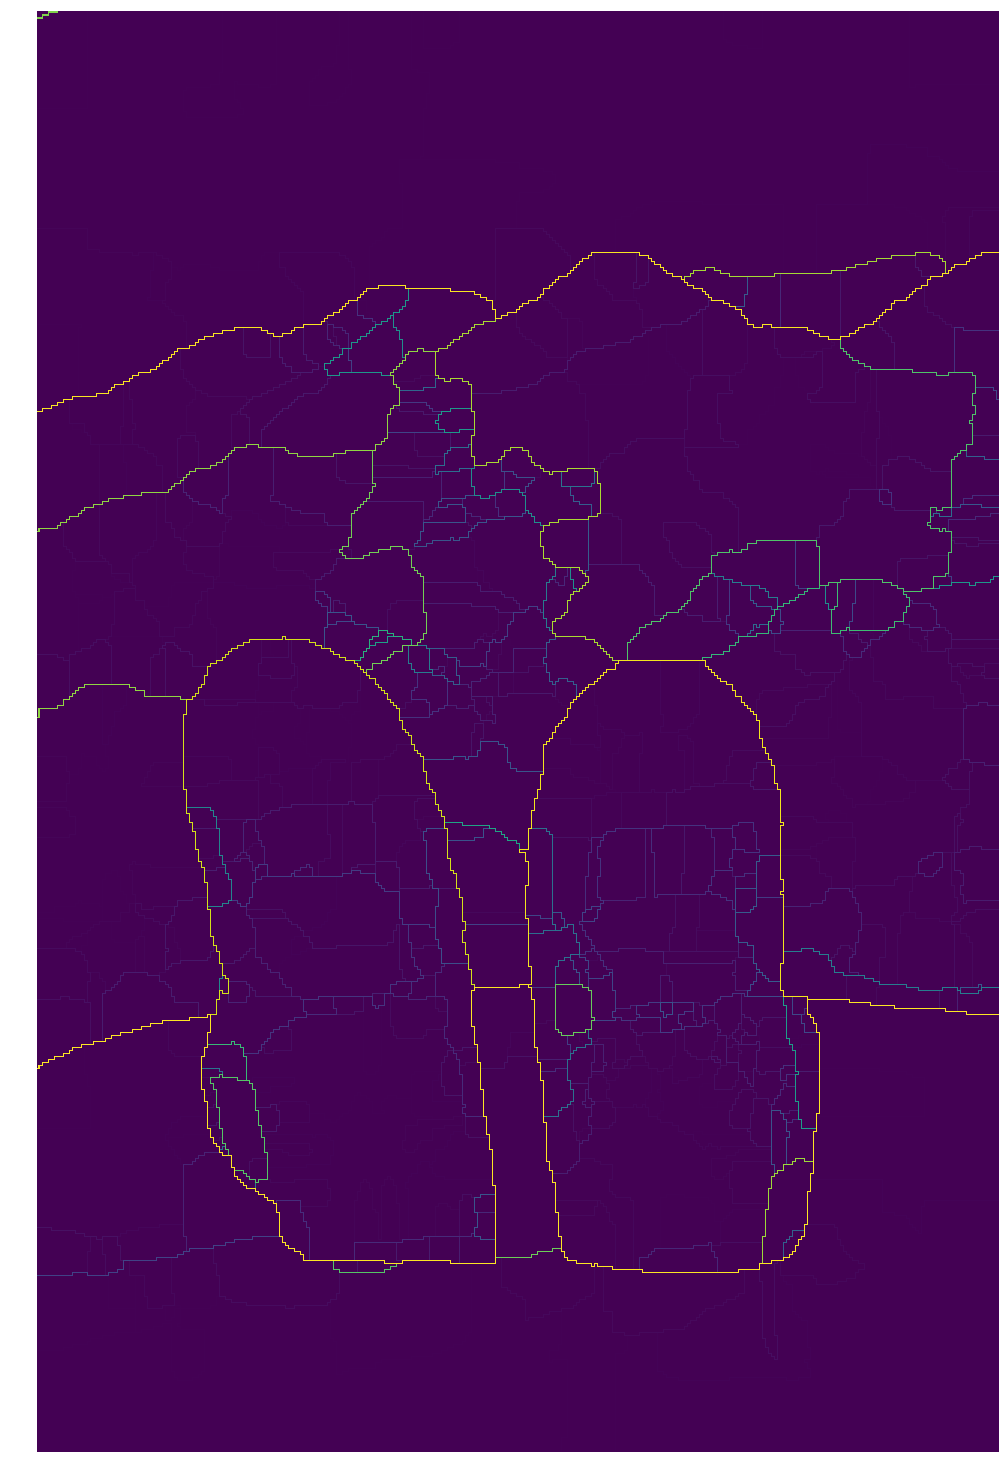

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f63040694a8>)

In [14]:
imshow(hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(combined_hierarchy, altitudes_combined)))

## Library API

The process described in this notebook can be reproduced using the provided higra function `hg.multiscale_mean_pb_hierarchy`

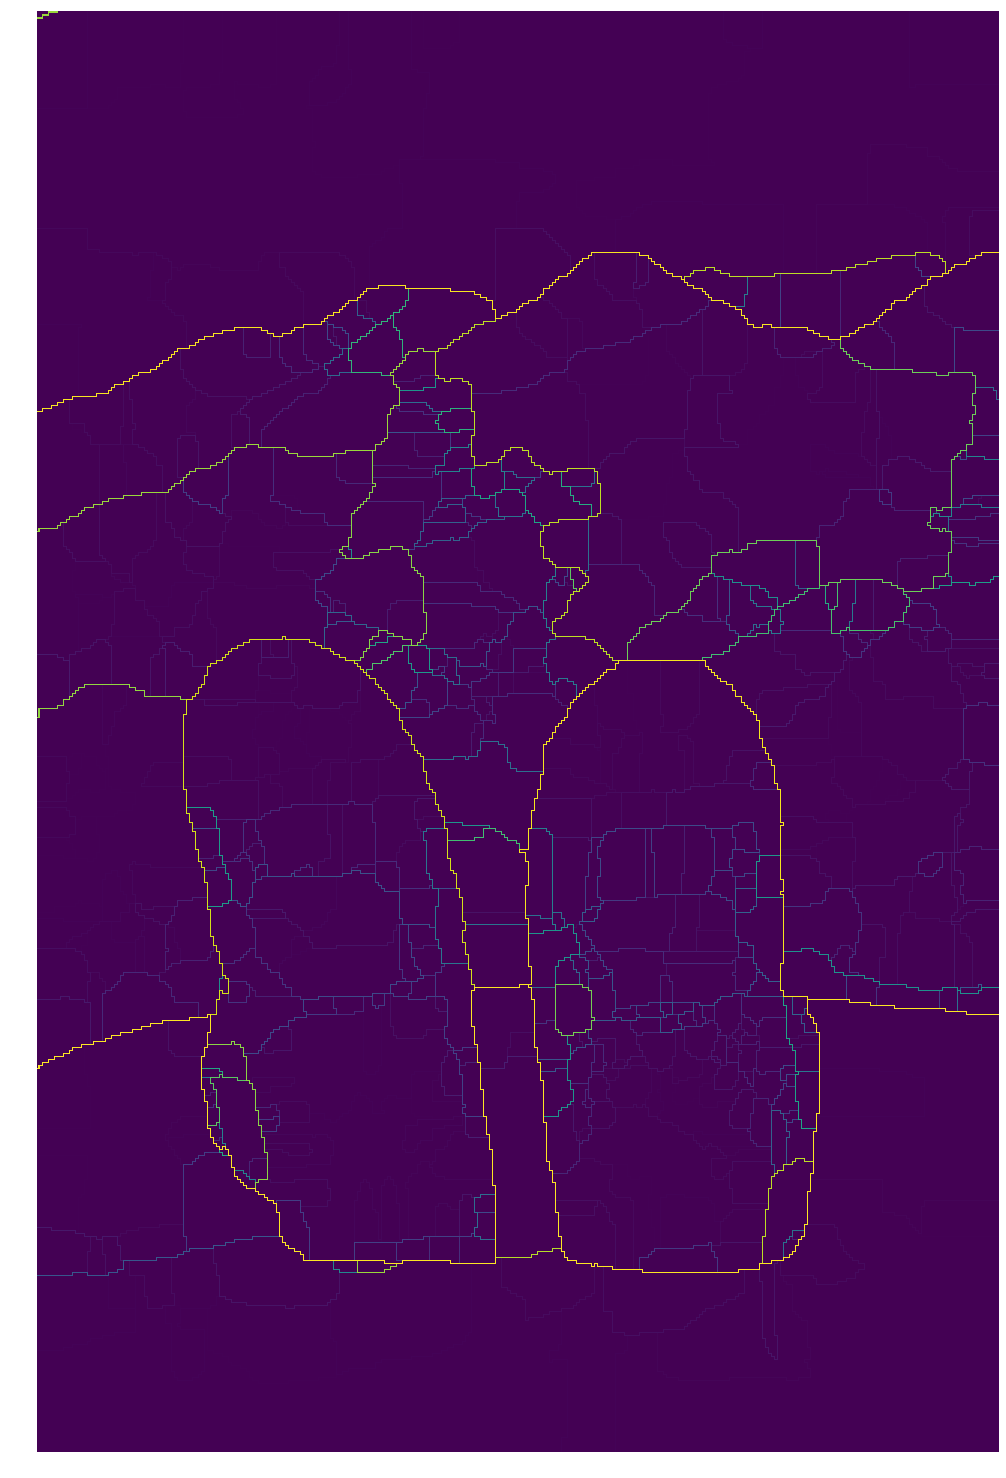

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f62fd79f2e8>)

In [15]:
combined_hierarchy, altitudes_combined = hg.multiscale_mean_pb_hierarchy(graph, edge_weights_fine, others_edge_weights=(edge_weights_coarse,), edge_orientations=edge_orientations)
imshow(hg.graph_4_adjacency_2_khalimsky(graph, hg.saliency(combined_hierarchy, altitudes_combined)))
